#Pandas

[Pandas](http://pandas.pydata.org/) je biblioteka za analizu podataka. Ilustrirat ćemo njeno korištenje na jednostavnom primjeru analize podataka iz IMDB baze.

Također ćemo koristiti biblioteku [pattern](http://www.clips.ua.ac.be/pages/pattern), koja služi za rudarenje podataka s Interneta. No kako iz Sagemath oblaka nemamo pristup IMDBu, podatke sam dohvatio lokalno.

Dohvaćamo podatke s IMDB-a o filmovima sa zemljom porijekla Hrvatska, smimljenim između 1945. i 2015.

In [ ]:
# ovo sam napravio lokalno, ne funkcionira unutar Sagemath oblaka!
from pattern import web
url = 'http://www.imdb.com/search/title'
params = dict(sort='num_votes,desc', start=1, title_type='feature', year='1945,2015',countries='hr', languages='hr')
r=[]
for i in range(1,150,50):
    params['start']=i
    r.append(requests.get(url, params=params))
    time.sleep(5)

Parsiranje podataka koje spremamo u datoteku `filmovi.txt`.

In [21]:
# ovo sam isto napravio lokalno!
with open('filmovi.txt','w') as f:
    for i in range(len(r)):
        dom = web.Element(r[i].text)
        for movie in dom.by_tag('td.title'):    
            title = movie.by_tag('a')[0].content
            year = movie.by_tag('span.year_type')[0].content
            try:
                genres = movie.by_tag('span.genre')[0].by_tag('a')
                genres = '|'.join([g.content for g in genres])
            except:
                genres = ''
            try:
                runtime = movie.by_tag('span.runtime')[0].content
            except:
                runtime = '0 mins'
            try:    
                rating = movie.by_tag('span.value')[0].content
            except:
                rating = '0'
            f.write('\t'.join((title, year, runtime, rating, genres))+'\n')

###Analiza podataka pomoću biblioteke Pandas

Prebacio sam datoteku `filmovi.txt` na Sagemath oblak.

In [37]:
import pandas as pd
names = ['title', 'year','runtime', 'rating', 'genres']
data = pd.read_csv('filmovi.txt', delimiter='\t', names=names).dropna()
print "Number of rows: %i" % data.shape[0]
data.head()

Number of rows: 127


,title,year,runtime,rating,genres
0,The Priest&#x27;s Children,(2013),93 mins.,6.8,Comedy|Drama
1,Metastases,(2009),82 mins.,7.7,Crime|Drama
2,Fine Dead Girls,(2002),77 mins.,7.3,Drama|Thriller
3,Vegetarian Cannibal,(2012),85 mins.,7.3,Drama
4,Sonja and the Bull,(2012),103 mins.,7.2,Comedy|Romance


In [38]:
clean_runtime = [int(v.split(' ')[0]) for v in data.runtime]
data['runtime'] = clean_runtime
data['year'] = [int(y[1:-1]) for y in data.year]
data.rating[data.rating=='-'] = '0';
clean_rating = [float(v) for v in data.rating]
data['rating'] = clean_rating
data.head()

,title,year,runtime,rating,genres
0,The Priest&#x27;s Children,2013,93,6.8,Comedy|Drama
1,Metastases,2009,82,7.7,Crime|Drama
2,Fine Dead Girls,2002,77,7.3,Drama|Thriller
3,Vegetarian Cannibal,2012,85,7.3,Drama
4,Sonja and the Bull,2012,103,7.2,Comedy|Romance


In [8]:
data[['year','runtime', 'rating']].describe()

,year,runtime
count,127.000000,127.000000
mean,2008.984252,79.574803
std,5.937484,35.645859
min,1980.000000,0.000000
25%,2007.500000,72.500000
50%,2011.000000,87.000000
75%,2013.000000,100.000000
max,2015.000000,200.000000


In [23]:
import numpy as np
data.runtime[data.runtime==0] = np.nan;

In [10]:
data.runtime.describe()

count    111.000000
mean      91.045045
std       20.041043
min       46.000000
25%       80.000000
50%       90.000000
75%      100.000000
max      200.000000
Name: runtime, dtype: float64

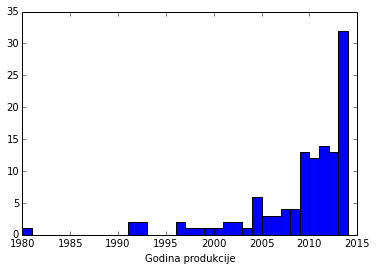

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(data.year, bins=np.arange(1945, 2015))
plt.xlabel("Godina produkcije");

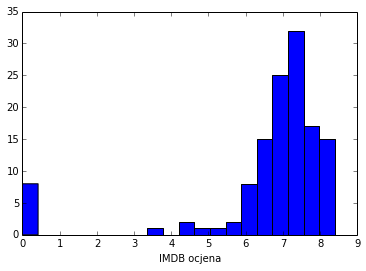

In [22]:
plt.hist(data.rating, bins=20)
plt.xlabel("IMDB ocjena");

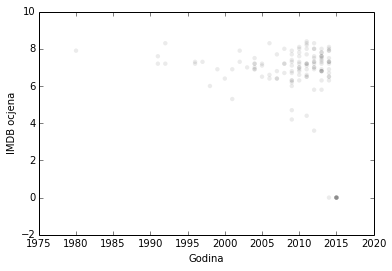

In [24]:
plt.scatter(data.year, data.rating, lw=0, alpha=.08, color='k')
plt.xlabel("Godina")
plt.ylabel("IMDB ocjena");

In [28]:
data.rating[data.rating==0] = np.nan;
data[data.rating == data.rating.min()][['title', 'year', 'rating', 'genres']]

,title,year,rating,genres
46,Larin izbor: Izgubljeni princ,2012,3.6,Drama


In [29]:
data[data.rating == data.rating.max()][['title', 'year', 'rating', 'genres']]

,title,year,rating,genres
106,Marija&#x27;s Own,2011,8.4,Comedy


In [30]:
genres = set()
for m in data.genres:
    genres.update(g for g in m.split('|'))
genres = sorted(genres)

for genre in genres:
    data[genre] = [genre in movie.split('|') for movie in data.genres]
         
data.head()

,title,year,runtime,rating,genres,Action,Adventure,Animation,Biography,Comedy,...,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,The Priest&#x27;s Children,2013,93,6.8,Comedy|Drama,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,Metastases,2009,82,7.7,Crime|Drama,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Fine Dead Girls,2002,77,7.3,Drama|Thriller,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,Vegetarian Cannibal,2012,85,7.3,Drama,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Sonja and the Bull,2012,103,7.2,Comedy|Romance,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False


In [31]:
genre_count = data[genres].sum()
pd.DataFrame({'Genre Count': genre_count})

,Genre Count
Action,11
Adventure,6
Animation,3
Biography,3
Comedy,36
Crime,9
Drama,87
Family,9
Fantasy,5
History,3


In [33]:
petoljetka =  (data.year // 5) * 5

tyd = data[['title', 'year']]
tyd['petoljetka'] = petoljetka;

tyd.head()

,title,year,petoljetka
0,The Priest&#x27;s Children,2013,2010
1,Metastases,2009,2005
2,Fine Dead Girls,2002,2000
3,Vegetarian Cannibal,2012,2010
4,Sonja and the Bull,2012,2010


year
1980    7.900000
1990    7.575000
1995    6.940000
2000    6.958333
2005    6.781481
2010    7.167143
2015         NaN
Name: Petoljetka mean, dtype: float64


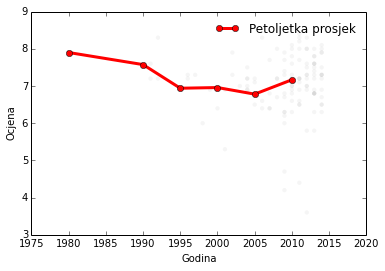

In [34]:
pet_mean = data.groupby(petoljetka).rating.mean()
pet_mean.name = 'Petoljetka mean'
print pet_mean

plt.plot(pet_mean.index, pet_mean.values, 'o-',
        color='r', lw=3, label='Petoljetka prosjek')
plt.scatter(data.year, data.rating, alpha=.04, lw=0, color='k')
plt.xlabel("Godina")
plt.ylabel("Ocjena")
plt.legend(frameon=False);

In [35]:
for year, subset in data.groupby('year'):
    print year, subset[subset.rating == subset.rating.max()].title.values

1980 ['Izgubljeni zavicaj']
1991 ['The Time of Warriors']
1992 ['Kamenita vrata']
1996 ['Putovanje tamnom polutkom']
1997 ['Lapitch the Little Shoemaker']
1998 ['Transatlantik']
1999 ['Red Dust']
2000 ['Celestial Body']
2001 ['The Miroslav Holdinc Co.']
2002 ['24 Hours']
2003 ['Bore Lee: U kandzama velegrada']
2004 ['The Society of Jesus']
2005 ['Snivaj, zlato moje']
2006 ['Crveno i crno']
2007 ['Play Me a Love Song']
2008 ['Blazeni Augustin Kazotic']
2009 ['Da mogu...']
2010 ['Prokletstvo Krumpira']
2011 ['Marija&#x27;s Own']
2012 ['Zagreb Stories Vol. 2']
2013 ['Simon Magus']
2014 ['Vlog']
2015 []
